In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler


In [42]:
train_df = pd.read_csv('tweets_data/train.csv')
test_df = pd.read_csv('tweets_data/test.csv')

# Overview of Dataset

Data Columns: 
* Text: The text of a tweet
* Keyword: A keyword from that tweet 
* Location: The location the tweet
* id: Tweet ID
* target: 1 if disaster was real, 0 if it is not

I will only be using the text of the tweet though.

# EDA

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(train_df.info())

Shape of data: (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


<Axes: xlabel='target', ylabel='count'>

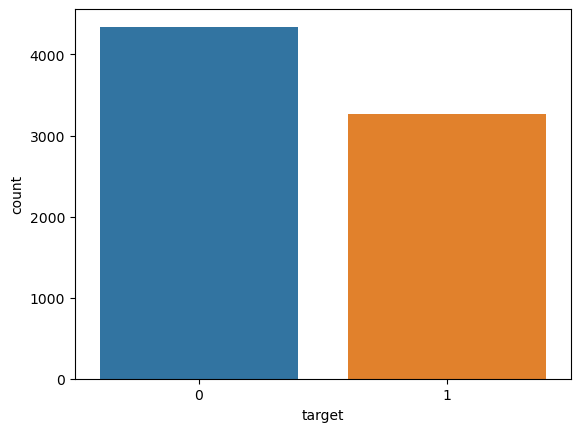

In [12]:
sns.countplot(x=train_df.target)

# Preprocessing

In [16]:
# balance dataset
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_df[['id','keyword', 'location', 'text']], train_df['target'])

<Axes: xlabel='target', ylabel='count'>

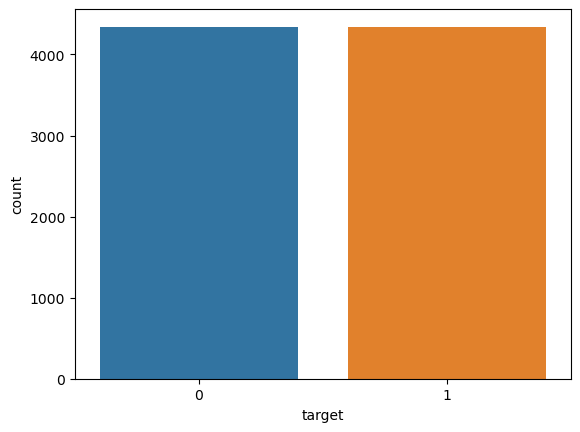

In [17]:
sns.countplot(x=y_resampled)

In [19]:
# Splitting the data into 2/3 as train and 1/3 as test
X_train, X_test, y_train, y_test = train_test_split(X_resampled['text'], y_resampled, test_size=0.33, random_state=42)

code help found here for preprocessing: https://www.kaggle.com/code/akashkr/tf-keras-tutorial-bi-lstm-glove-gru-part-6

In [47]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

# Modelling
I am using a GRU model because I found it to tbe the most interesting model that we discussed in class. I think that it has the best performance while also being the most simple to use. 

### GRU
A gated recurrent unit (GRU) is a gating mechanism in recurrent neural networks (RNN) similar to a long short-term memory (LSTM) unit but without an output gate. GRU’s try to solve the vanishing gradient problem that can come with standard recurrent neural networks.

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 5
history_gru = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              31488     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 192,269
Trainable params: 192,269
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
182/182 [==============================] - 32s 135ms/step - loss: 0.5694 - accuracy: 0.6894 - val_loss: 

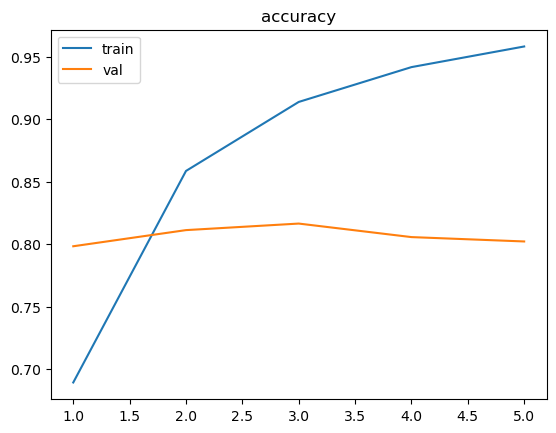

In [38]:
# plot line
epochs = range(1,6)
plt.plot(epochs, history_gru.history['accuracy'], label = 'train')
plt.plot(epochs, history_gru.history['val_accuracy'], label = 'val')
plt.legend()
plt.title('accuracy')
plt.show()

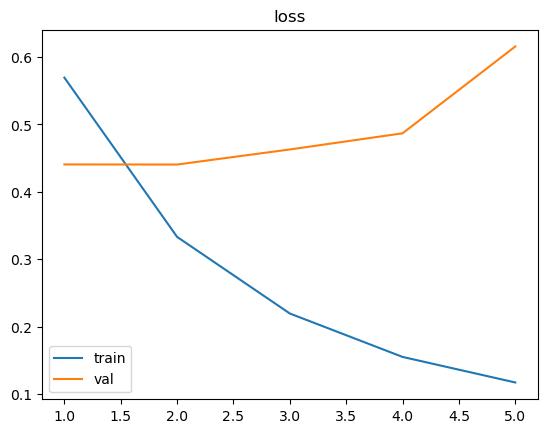

In [39]:
epochs = range(1,6)
plt.plot(epochs, history_gru.history['loss'], label = 'train')
plt.plot(epochs, history_gru.history['val_loss'], label = 'val')
plt.legend()
plt.title('loss')
plt.show()

# Discussion/Conclusion

The original Goal of this project was to identify if a given disaster tweet was about a real disaster or if it was not. To do this I decided to use a GRU model for the classifcation because I thought it was the most interesting model discussed in the course. 

The GRU model that I trained acheived a training accuracy of .9581, which is really good, until the validation accuracy is viewed, I only acheived a validation accuracy of .8022. This is still a good accuracy level when considering it is a basic text classification model, but in the real world I would like something better. 

This difference in accuracy between the test and train datasets I believe indicates some over fitting of the model. To avoid this in the future, I would potentially try to find a more diverse set of tweets, or even use an undersampler as opposed to an over sampler that I used in this notebook.

Potentially another model would have performed better as well.

# Create output

In [49]:
preds = model.predict(testing_padded)

102/102 [==============================] - 4s 39ms/step


In [74]:
np.around(preds).shape
#test_df['id'].values

output = pd.DataFrame(test_df['id'].values)
output['target'] = np.around(preds)
output.columns = ['Id', 'target']
output.to_csv('output.csv', index = False)
output

,Id,target
0,0,0.0
1,2,0.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,1.0
